In [0]:
cd /content/drive/My Drive/kaggle/Bengali.AI competition

/content/drive/My Drive/kaggle/Bengali.AI competition


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Data Import

In [0]:
data_dir = 'data/'
files_train = [f'train_image_data_{fid}.parquet' for fid in range(4)]
files_train
# 원래 kaggle에서는 이렇게 4개의 dataset이 있다
# 나는 저장공간이 부족해서 1개로만 연습한다

['train_image_data_0.parquet',
 'train_image_data_1.parquet',
 'train_image_data_2.parquet',
 'train_image_data_3.parquet']

In [0]:
F = os.path.join(data_dir, files_train[0])
F

'data/train_image_data_0.parquet'

In [0]:
train0 = pd.read_parquet(F)
# dataset이 여러개면 for문을 이용한다

In [0]:
print(train0.shape)
train0.head()

(50210, 32333)


,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,32292,32293,32294,32295,32296,32297,32298,32299,32300,32301,32302,32303,32304,32305,32306,32307,32308,32309,32310,32311,32312,32313,32314,32315,32316,32317,32318,32319,32320,32321,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,253,254,253,253,253,254,253,252,253,253,253,253,252,252,253,253,252,252,253,252,252,252,253,254,253,253,252,252,252,253,...,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,252,250,250,246,249,248,250,249,251,252,253,253,253,253,253,253,253,250,249,251,252,251,251,251,251,252,253,251,250,252,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,252,253,252,252,251,250,251,253,254,251,251,252,252,253,253,252,251,251,249,251,252,252,253,252,251,251,251,250,250,252,...,253,253,252,252,252,253,253,253,253,253,252,251,251,250,250,250,251,251,251,250,250,250,251,252,253,253,253,253,254,254,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,250,251,250,249,251,251,251,250,252,251,245,245,251,252,251,252,252,250,249,250,251,250,249,250,251,252,253,252,252,252,...,253,252,252,254,253,253,254,253,252,253,254,253,252,253,254,254,254,254,254,254,254,254,253,252,253,254,253,252,253,254,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,225,231,229,229,228,221,224,226,221,221,220,217,217,218,219,222,224,214,218,227,227,227,228,224,231,235,235,233,212,183,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255


In [0]:
137 * 236
# 각 row가 하나의 image를 의미한다는 것을 알 수 있다

32332

# Image visualization

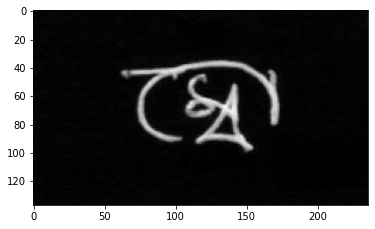

In [0]:
# 데이터를 reshape하여 살펴본다
idx = np.random.randint(len(train0))
img = train0.iloc[idx, 1:].to_numpy().astype(np.uint8) # 이미지 데이터는 최대값이 255니까

plt.imshow(255 - img. reshape(137, 236), cmap='gray')

# Multi-label stratification folding

In [0]:
df_train = pd.read_csv('data/train.csv')
df_train.head()
# train data의 target이 있는 df
# 근데 class가 불균형이다 이를 validation위해 fold를 나눠보자

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [0]:
df_train.shape

(200840, 5)

In [0]:
!pip install iterative-stratification
# sklearn은 multilabel은 제공하지 않는다고 한다

In [0]:
df_train['id'] = df_train['image_id'].apply(lambda x : int(x.split('_')[1]))

In [0]:
X = df_train.to_numpy()[:, 4] # id
y = df_train.to_numpy()[:, 1:4] # target values

In [0]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

mskf = MultilabelStratifiedKFold(n_splits=6, random_state=0)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [0]:
df_train['fold'] = -1

In [0]:
for i, (trn_idx, vld_idx) in enumerate(mskf.split(X,y)):
    df_train.loc[vld_idx, 'fold'] = i

In [0]:
df_train['fold'].value_counts()
# 잘 나눠졌다

2    33474
1    33474
5    33473
4    33473
3    33473
0    33473
Name: fold, dtype: int64

In [0]:
# 저장해서 쓰자
# df_train.to_csv('data/df_folds.csv', index=False)

# Efficient learning process
- pandas말고 더 빠르게 사용하자.

In [0]:
import joblib
from tqdm import tqdm # 진행상태를 보여주기 위해

In [0]:
F

'data/train_image_data_0.parquet'

In [0]:
# 더 빠르게 만들기위해 numpy로 바꾼다
img_ids = train0['image_id'].to_numpy()
img_array = train0.iloc[:, 1:].to_numpy(dtype=np.uint8)

# 각 data 마다 pkl로 저장
for idx in tqdm(range(len(train0))):
     img_id = img_ids[idx]
     img = img_array[idx]
     joblib.dump(img, f'data/train_image/{img_id}.pkl')

# pytorch dataset

일단 data 하나로 연습해보자.

In [0]:
index = 0
HEIGHT = 137
WIDTH = 236

In [0]:
img_id = train0['image_id'][index]
img = joblib.load(f'data/train_image/{img_id}.pkl').astype(np.uint8)
img = img.reshape(HEIGHT, WIDTH)

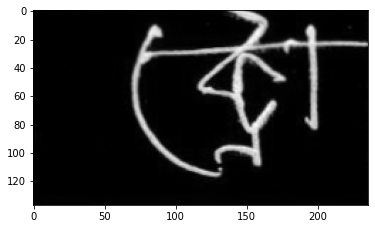

In [0]:
plt.imshow(255-img, cmap='gray')

In [0]:
img.shape

(137, 236)

In [0]:
# pytorch model에 넣기 위해 channel을 만들어준다.
img = img[:,:, np.newaxis]
print(img.shape)

(137, 236, 1)


In [0]:
label_1 = df_train.iloc[index, 1] # grapheme_root
label_2 = df_train.iloc[index, 2] # vowel_diacritic
label_3 = df_train.iloc[index, 3] # consonant_diacritic

위의 과정을 class로 구현해보자

In [0]:
import torch
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings('ignore')

In [0]:
# pytorch model에 넣기 위해서는 image data의 shape가 (Batch, Channel, Height, Width) 이여야 한다고 한다.

class BengaliDataset(Dataset):
    def __init__(self, csv, img_height, img_width):
        self.csv = csv.reset_index()
        self.img_ids = csv['image_id'].to_numpy()
        self.img_height = img_height
        self.img_width = img_width

    def __len__(self):
        return len(csv)

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = joblib.load(f'data/train_image/{img_id}.pkl')
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        img = 255 - img
        img = img[:, :, np.newaxis]
        
        label_1 = self.csv.iloc[index].grapheme_root
        label_2 = self.csv.iloc[index].vowel_diacritic
        label_3 = self.csv.iloc[index].consonant_diacritic

        return (torch.tensor(img, dtype=torch.float).permute(2,0,1),
                torch.tensor(label_1, dtype=torch.long),
                torch.tensor(label_2, dtype=torch.long),
                torch.tensor(label_3, dtype=torch.long)) # 나중에 softmax 사용을 위해 long으로 해야한다고 한다

In [0]:
# 이제 train/valid set을 만들어보자

df_train['fold'] = pd.read_csv('data/df_folds.csv')['fold']

In [0]:
trn_fold = [i for i in range(6) if i not in [5]]
vld_fold = [5]

In [0]:
trn_idx = df_train.loc[df_train['fold'].isin(trn_fold)].index
vld_idx = df_train.loc[df_train['fold'].isin(vld_fold)].index

In [0]:
trn_idx # 이래서 reset_index가 필요했던것

Int64Index([     0,      1,      2,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            200828, 200830, 200831, 200832, 200833, 200835, 200836, 200837,
            200838, 200839],
           dtype='int64', length=167367)

In [0]:
trn_dataset = BengaliDataset(csv=df_train.loc[trn_idx], img_height=HEIGHT, img_width=WIDTH)

In [0]:
trn_dataset[0]

(tensor([[[1., 2., 3.,  ..., 1., 2., 4.],
          [0., 2., 2.,  ..., 1., 2., 3.],
          [0., 0., 0.,  ..., 1., 1., 2.],
          ...,
          [1., 1., 2.,  ..., 2., 1., 3.],
          [1., 1., 1.,  ..., 2., 2., 3.],
          [1., 1., 1.,  ..., 2., 2., 4.]]]), tensor(15), tensor(9), tensor(5))